In [1]:
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
import os
import scipy
import hdf5storage
import json
from collections import Counter

from feature_selection import feature_selection, HDA, epiScanpy, Signac
from tool import *

# Read Data

In [2]:
select_num = 20000
seed_base = 2
filter_para = 0.01

In [6]:
print('load dataset...')
file_path = '../data/Buenrostro2018.h5ad'
ATAC_all = sc.read_h5ad(file_path)
ATAC_all.X = scipy.sparse.csc_matrix(ATAC_all.X)
ATAC_all
# ATAC_count = np.load(file_path + '/atac_count.npz')['arr_0']
# with open(file_path + '/atac.json','r',encoding='utf8') as fp:
#     ATAC = json.load(fp)
# label = ATAC['cell_name']
# peaks = []
# for peak in ATAC['peak_name']:
#     peaks.append(peak[0]+'_'+peak[1]+'_'+peak[2])
# peaks = np.array(peaks)
# ATAC_all = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count))
# ATAC_all.obs['label'] = ATAC['cell_name']
# ATAC_all.var_names = peaks
# ATAC_all

load dataset...


AnnData object with n_obs × n_vars = 2034 × 100934
    obs: 'label'

In [7]:
Counter(ATAC_all.obs['label'])

Counter({'HSC': 347,
         'MPP': 142,
         'LMPP': 160,
         'CMP': 502,
         'CLP': 78,
         'MEP': 138,
         'GMP': 216,
         'pDC': 141,
         'mono': 64,
         'UNK': 60,
         'GMP3high': 74,
         'GMP2mid': 44,
         'GMP1low': 68})

# Feature Selection

In [8]:
idx, ATAC_object, ATAC_count_filter = feature_selection(ATAC_all, select_num, seed_base, filter_para)

AnnData object with n_obs × n_vars = 2034 × 100934
    obs: 'label'
Preselect peaks that are accessible in more than 1.0% of cells.
View of AnnData object with n_obs × n_vars = 2034 × 100934
    obs: 'label'
(100934, 100)
processing...0/100934 0%
processing...10000/100934 9%
processing...20000/100934 19%
processing...30000/100934 29%
processing...40000/100934 39%
processing...50000/100934 49%
processing...60000/100934 59%
processing...70000/100934 69%
processing...80000/100934 79%
processing...90000/100934 89%
processing...100000/100934 99%
processing...100934/100934 100%
First fitting.
Second fitting.
Third fitting.


# Evaluation

## Evaluate by cell clustering

In [9]:
print('After selecting peaks, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_count_filter = PCA(n_components=10,random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
print('After PCA, the matrix dimensions are reduced to {}'.format(ATAC_count_filter.shape))
ATAC_pca = sc.AnnData(scipy.sparse.csc_matrix(ATAC_count_filter),dtype = 'float32')
ATAC_pca.obs['label'] = list(ATAC_all.obs['label'])

sc.pp.neighbors(ATAC_pca, n_neighbors=15, use_rep='X',random_state=seed_base*1000)
louvain_df = run_louvain(ATAC_pca,'label','cluster',seed=int(seed_base*1000))
print("cluster results:")
print(louvain_df)
ATAC_pca.obsm['latent'] = scipy.sparse.csc_matrix(ATAC_count_filter)
print("ASW:")
print(silhouette(adata=ATAC_pca, group_key='label', embed='latent'))
ATAC_pca.obsm['X_emb'] = scipy.sparse.csc_matrix(ATAC_count_filter)
ATAC_pca.obs['label'] = ATAC_pca.obs['label'].astype('category')
print("cLISI:")
print(clisi_graph(adata=ATAC_pca, label_key='label', type_='embed'))

After selecting peaks, the matrix dimensions are reduced to (2034, 20000)


After PCA, the matrix dimensions are reduced to (2034, 10)
Clustering...
resolution: 0.1, NMI: 0.4285963161377099, ARI: 0.1744403291253998, Homo: 0.31904172911269346, AMI: 0.4255108176981857
resolution: 0.2, NMI: 0.48856488078174426, ARI: 0.21665016124237763, Homo: 0.38400549230903935, AMI: 0.4850706139633982
resolution: 0.3, NMI: 0.539995092329968, ARI: 0.34749159874921826, Homo: 0.5008771129429037, AMI: 0.5353463608426244
resolution: 0.4, NMI: 0.5406086985765957, ARI: 0.34839822555677696, Homo: 0.5013672968651403, AMI: 0.5359651954003274
resolution: 0.5, NMI: 0.5008268436909987, ARI: 0.2839053763332932, Homo: 0.48175497792053185, AMI: 0.4952614939115158
resolution: 0.6, NMI: 0.5170395229908389, ARI: 0.27992511035471673, Homo: 0.5172591885639495, AMI: 0.5105072664274736
resolution: 0.7, NMI: 0.5505647881984763, ARI: 0.34487614342264494, Homo: 0.5607532774369527, AMI: 0.5439605801476021
resolution: 0.8, NMI: 0.5388388393388128, ARI: 0.3112598362482217, Homo: 0.5680354296621043, AMI: 0.

## UMAP

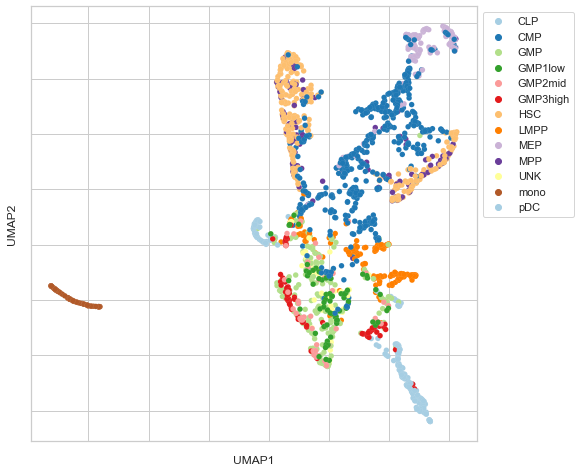

In [10]:
# umap
sns.set_theme(style='whitegrid')
label = ATAC_pca.obs['label']
proj = umap.UMAP(random_state=int(seed_base*1000)).fit_transform(ATAC_count_filter)
fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
df = {'UMAP1':proj[:, 0],\
    'UMAP2':proj[:, 1], \
    'label':label}
df = pd.DataFrame(df)
a = np.unique(df['label'])
palet = sns.color_palette("Paired",a.shape[0])
ax = sns.scatterplot(x="UMAP1", y="UMAP2", hue="label", palette=palet, s=30,linewidth = 0.05, data=df)
ax.legend(bbox_to_anchor=(1,1))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()